## Error and Correlation from all 3 models for CARTOON 50 images

In [5]:
# Initialize these:
path = "E:/GitRepo/Color-Concept-Associaitons-using-Google-Images/downloads"  #<Replace the path here>
sz = 100
filepath = 'dataCartoon50.xlsx'

# strtInd is used to keep track of beginning of the rows of a new category in the data matrix
# Copied from 01_getFeatures_cartoon_50.ipynb
strtInd = [0, 2900, 5800, 8700, 11600, 14500, 17400, 20300, 23200, 26100, 29000, 31900, 34800]

In [6]:
 # Include imports
import glob
from skimage.transform import resize
from skimage.io import imread, imsave, imshow
import os
import pandas as pd
import numpy as np
import skimage.color as skcolor
import matplotlib.pyplot as plt

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [7]:
colNames = ["col_"+str(i) for i in range(58)] 
allConcepts = ['mango','watermelon','honeydew','cantaloupe','grapefruit','strawberry','raspberry','blueberry','avocado','orange','lime','lemon']

# Read data
# Get the color ratings data -From file data.csv
data = pd.read_csv("data.csv",names = colNames)

# Get the LAB coordinates of colors from file Lab.csv

colorData = pd.read_csv("Lab.csv",header=None)
colorDataRGB = pd.read_csv("RGB.csv",header=None)

In [8]:
df = pd.read_excel(filepath)
Q = df.as_matrix()
Q.shape

(34800, 187)

In [6]:
X = np.copy(Q[:,:-1])
y = np.copy(Q[:,-1])
print(X.shape, y.shape)

(34800, 186) (34800,)


In [7]:
# Function to computer error, correlation and rating for LOO fruit category 
# based on the features selected from Analysis (sparse regression)
from scipy import stats
        
def getRatings(minErrFeature):
    win0 = []
    win1 = []
    win2 = []
    xNew = np.column_stack([X[:,minErrFeature],y])
    correlation = []
    error = []

    # Linear Regression using Cross Validation
    # Leave one out cross validation -- strtInd holds the starting indices of set of fruit data 
    xTemp = np.copy(xNew)

    for i in range(len(strtInd)-1):
        # Leave one entire fruit group
        testFruit =  allConcepts[i]
        #print("\nLeaving out fruit group : ",allConcepts[i])
        testTemp = np.copy(xTemp[strtInd[i]:strtInd[i+1],:]) # Get all rows from the LOO group
        trainTemp = np.delete(xTemp,range(strtInd[i],strtInd[i+1]),0)
        row = len(trainTemp)
        #Training set
        X_train = np.column_stack([np.ones((row,1)), trainTemp[:,:-1]]) # add offset
        y_train = np.copy(trainTemp[:,-1])
        # Test set (hold out set)
        row2 = len(testTemp)
        X_test  = np.column_stack([np.ones((row2,1)), testTemp[:,:-1]]) #xTemp[row:tot,0:3]#
        y_test  = np.copy(testTemp[:,-1])


        # Create linear regression object
        regr = linear_model.LinearRegression(fit_intercept=False)
        # Train the model using the training sets
        regr.fit(X_train, y_train)

        # Make predictions using the testing set
        y_pred = regr.predict(X_test)
        print("Score is : %.2f" % regr.score(X_test, y_test))
        # The coefficients
        print('Coefficients: ', regr.coef_)
        #print('Intercept: \n', regr.intercept_)
        # The mean squared error
        print("\nMean squared error: %.4f"
              % mean_squared_error(y_test, y_pred))
        # Explained variance score: 1 is perfect prediction
        print('Variance score: %.2f' % r2_score(y_test, y_pred))

        ############## For test purposes - Average prediction over all Images of LOO group ############
        totalTestImages = y_pred.size/58  #58N rows -> every image has 58 rows of data
        avg_pred = [np.sum([y_pred[p] for p in range(q,y_pred.size,58)])/totalTestImages for q in range(58)]

        # For Pearson correlation coefficient and the p-value (between avg_pred and true rating for fruit group)
        trueRating = np.copy(y_test[0:58])

        sqErr = np.sum(pow(avg_pred - trueRating,2))
        print("The true squared error (in color ratings) for left out fruit",testFruit,"is: %.4f" % sqErr)

        corrCoeff, pVal = stats.pearsonr(avg_pred, trueRating)
        print("\nPearson’s correlation coefficient (between true ratings and avg predicted ratings) is %.4f" %corrCoeff)
        print("p-value %.4f" %pVal)

        error.append(sqErr)
        correlation.append(corrCoeff)
        win0.append(corrCoeff) # saves correlation for test fruit
        win1.append(trueRating) # saves true rating for test fruit
        win2.append(avg_pred)   # saves avg predicted rating for test fruit
        # Plot average color rating over all test images.
        fig= plt.figure(figsize=(10,3))
        barPlot = plt.bar(range(1,59), avg_pred,color = colorDataRGB.values)
        plt.ylabel('Ratings')
        plt.xlabel('Colors')
        plt.title('Predicted color ratings for Fruit Group : %s' %testFruit)
        plt.xticks([i for i in range(1,59,3)],[i for i in range(1,59,3)])
        plt.ylim(0,1)
        plt.show()

        fig= plt.figure(figsize=(10,3))
        barPlot = plt.bar(range(1,59), trueRating,color = colorDataRGB.values)
        plt.ylabel('Ratings')
        plt.xlabel('Colors')
        plt.title('True color ratings for Fruit Group : %s' %testFruit)
        plt.xticks([i for i in range(1,59,3)],[i for i in range(1,59,3)])
        plt.ylim(0,1)
        plt.show()

        # Scatter plot
        fig2 = plt.figure(figsize=(7,7))
        plt.scatter(trueRating,avg_pred,c=colorDataRGB.values,marker = 'o',linewidths=2.5)
        plt.ylabel('Predicted Ratings')
        plt.xlabel('Subject Ratings')
        plt.title('Scatter plot of color ratings for : %s' %testFruit)
        plt.axis('equal')
        plt.xlim(0,1)
        plt.ylim(0,1)
        plt.show() 
    return error, correlation, win0, win1, win2

# Regression on top 3 spherical features

Score is : 0.35
Coefficients:  [ 0.17158504  0.34964224 -0.23543196  0.20908341]

Mean squared error: 0.0218
Variance score: 0.35
The true squared error (in color ratings) for left out fruit mango is: 1.0906

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.8003
p-value 0.0000


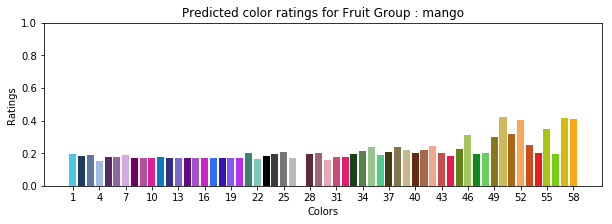

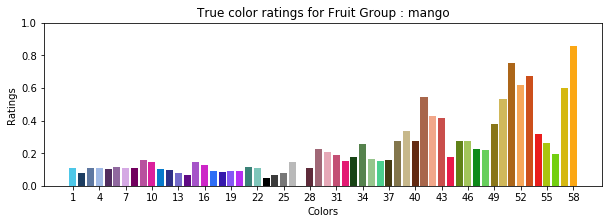

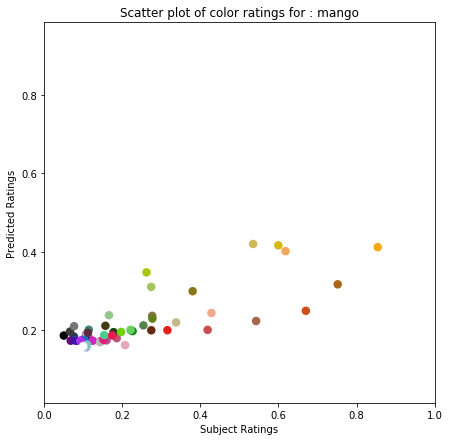

Score is : 0.02
Coefficients:  [ 0.16610167  0.37928013 -0.24083221  0.20680351]

Mean squared error: 0.0361
Variance score: 0.02
The true squared error (in color ratings) for left out fruit watermelon is: 1.6940

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.6125
p-value 0.0000


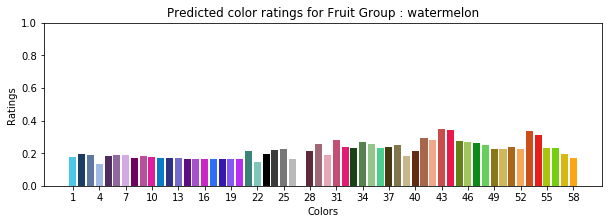

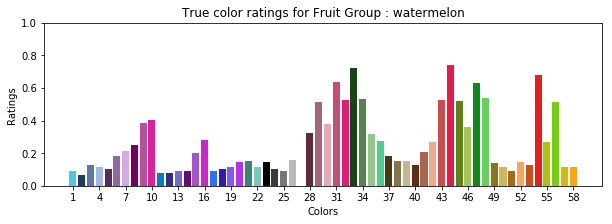

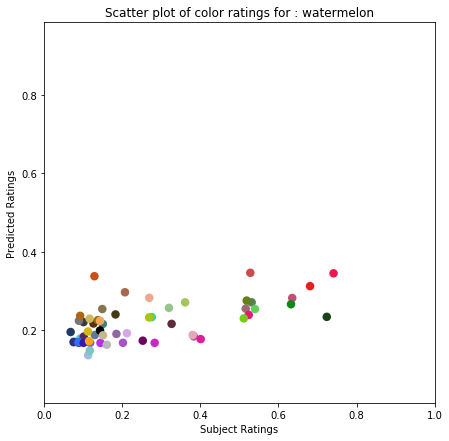

Score is : 0.18
Coefficients:  [ 0.17013814  0.35521835 -0.22839955  0.22250417]

Mean squared error: 0.0165
Variance score: 0.18
The true squared error (in color ratings) for left out fruit honeydew is: 0.7222

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.6489
p-value 0.0000


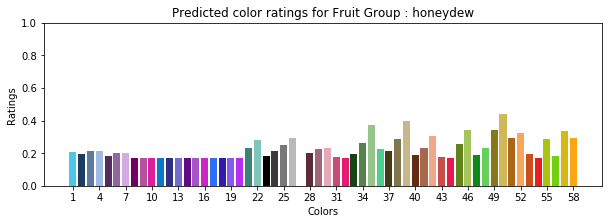

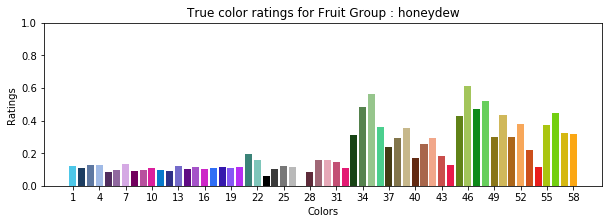

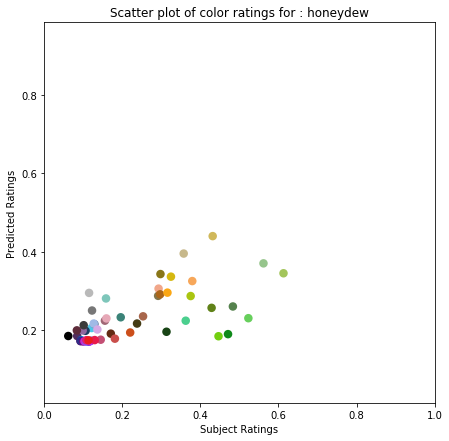

Score is : 0.31
Coefficients:  [ 0.17092255  0.37106164 -0.23811821  0.20495581]

Mean squared error: 0.0215
Variance score: 0.31
The true squared error (in color ratings) for left out fruit cantaloupe is: 0.8762

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.8060
p-value 0.0000


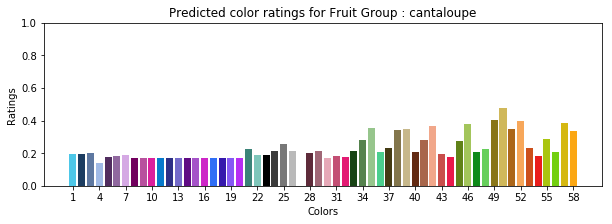

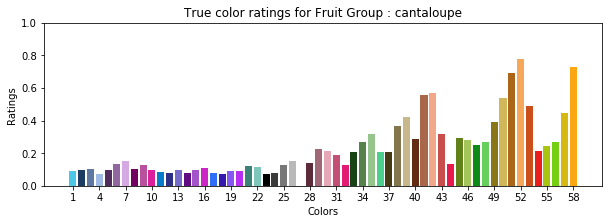

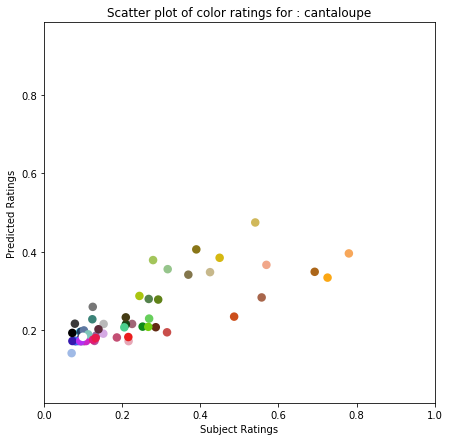

Score is : 0.23
Coefficients:  [ 0.16901391  0.36315552 -0.23655876  0.21011481]

Mean squared error: 0.0188
Variance score: 0.23
The true squared error (in color ratings) for left out fruit grapefruit is: 0.8116

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.8140
p-value 0.0000


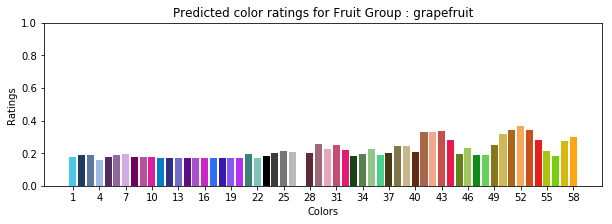

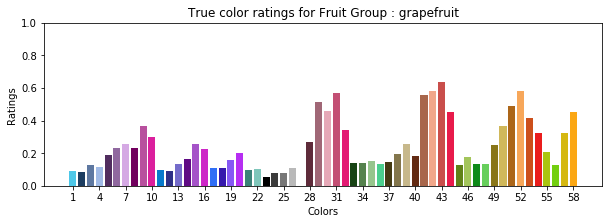

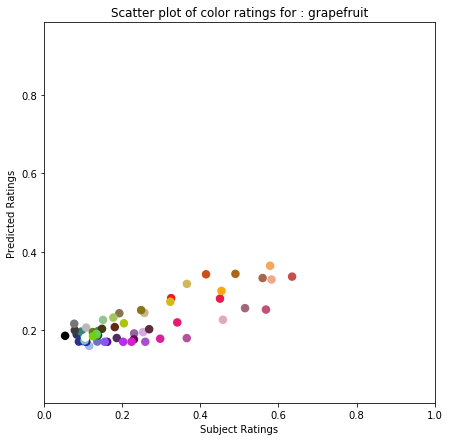

Score is : 0.16
Coefficients:  [ 0.16938007  0.36932355 -0.23947736  0.20847606]

Mean squared error: 0.0229
Variance score: 0.16
The true squared error (in color ratings) for left out fruit strawberry is: 1.1120

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.5961
p-value 0.0000


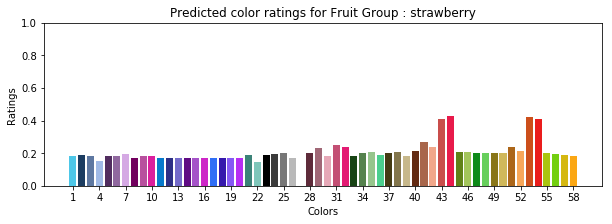

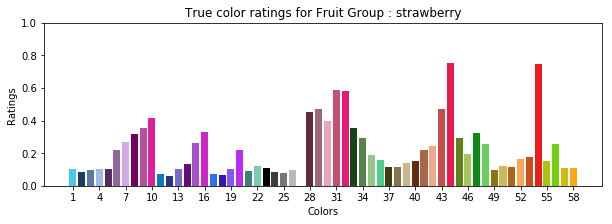

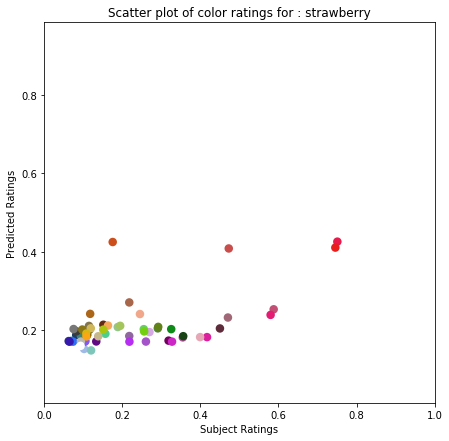

Score is : 0.23
Coefficients:  [ 0.17119935  0.37291228 -0.24027618  0.20319074]

Mean squared error: 0.0183
Variance score: 0.23
The true squared error (in color ratings) for left out fruit raspberry is: 0.8878

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.6184
p-value 0.0000


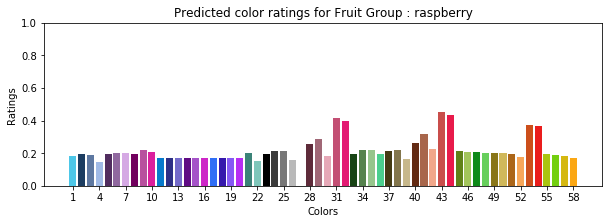

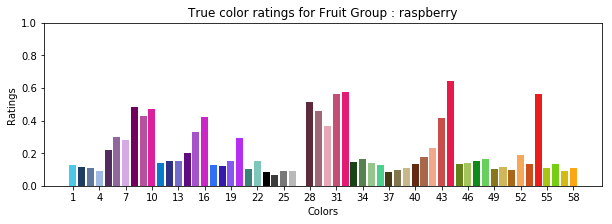

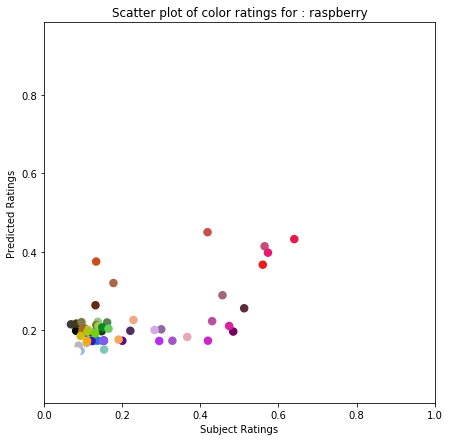

Score is : 0.19
Coefficients:  [ 0.17149762  0.36476449 -0.24382309  0.21593099]

Mean squared error: 0.0343
Variance score: 0.19
The true squared error (in color ratings) for left out fruit blueberry is: 1.6109

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.6680
p-value 0.0000


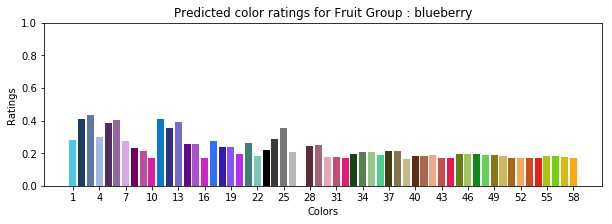

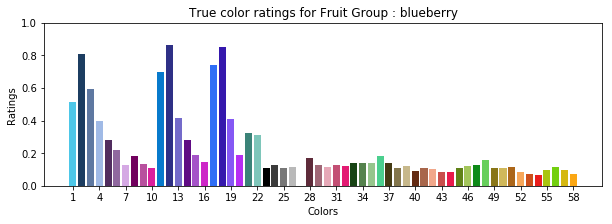

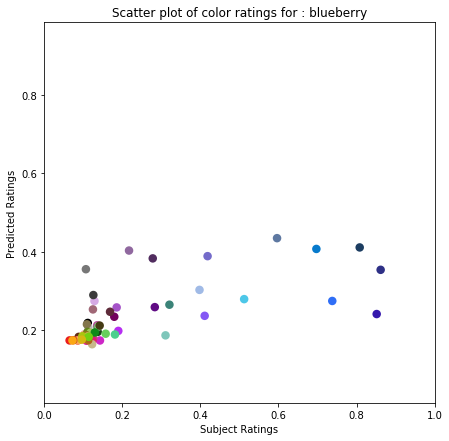

Score is : 0.16
Coefficients:  [ 0.17339087  0.38865963 -0.23718687  0.18690924]

Mean squared error: 0.0302
Variance score: 0.16
The true squared error (in color ratings) for left out fruit avocado is: 1.4894

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.6085
p-value 0.0000


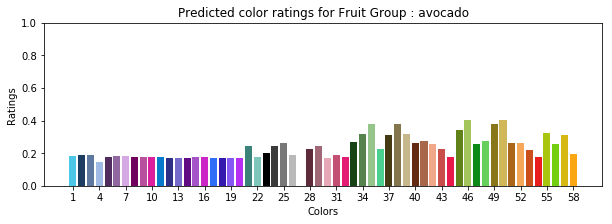

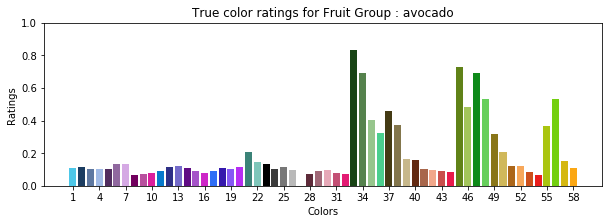

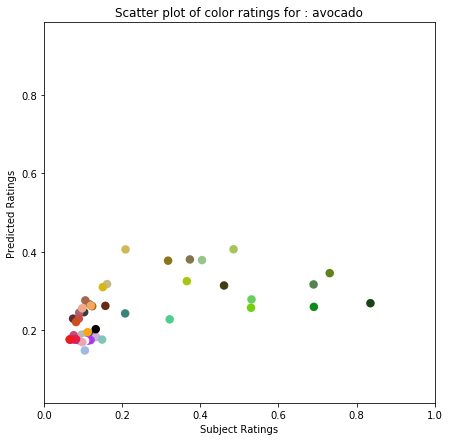

Score is : 0.46
Coefficients:  [ 0.17466965  0.35346341 -0.23873492  0.19596037]

Mean squared error: 0.0200
Variance score: 0.46
The true squared error (in color ratings) for left out fruit orange is: 1.0055

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.8620
p-value 0.0000


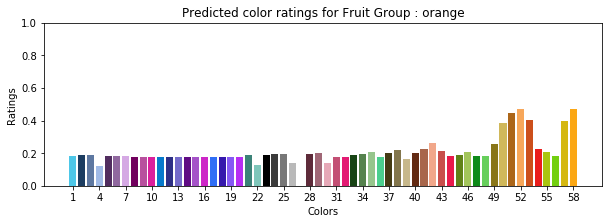

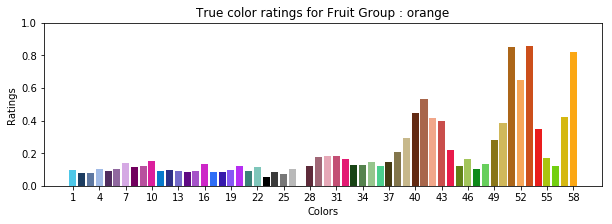

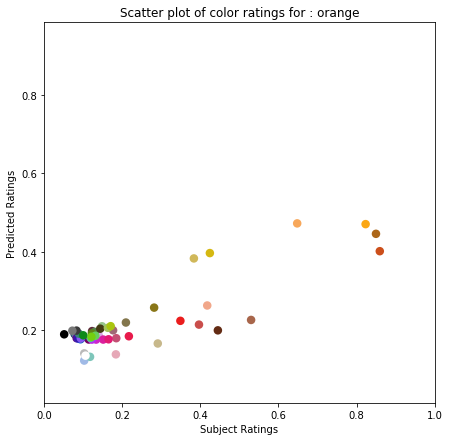

Score is : 0.39
Coefficients:  [ 0.17528978  0.34823892 -0.2293444   0.20010116]

Mean squared error: 0.0269
Variance score: 0.39
The true squared error (in color ratings) for left out fruit lime is: 1.3379

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.8586
p-value 0.0000


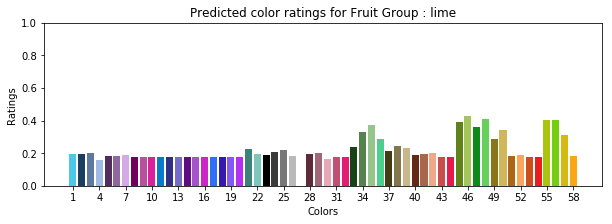

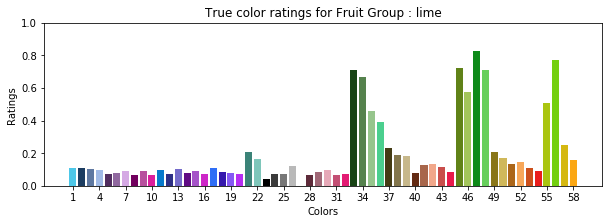

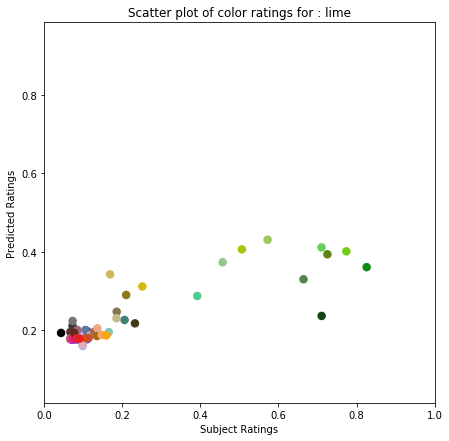

Score is : 0.46
Coefficients:  [ 0.17548579  0.34859196 -0.24452487  0.20965158]

Mean squared error: 0.0140
Variance score: 0.46
The true squared error (in color ratings) for left out fruit lemon is: 0.6817

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.8706
p-value 0.0000


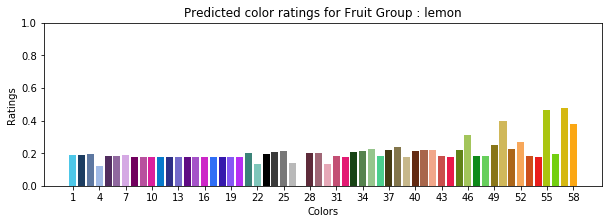

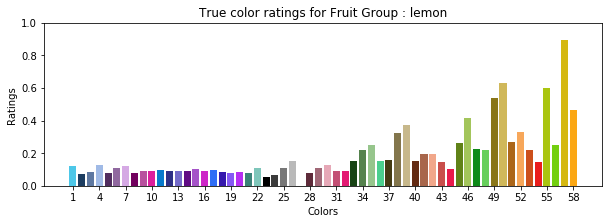

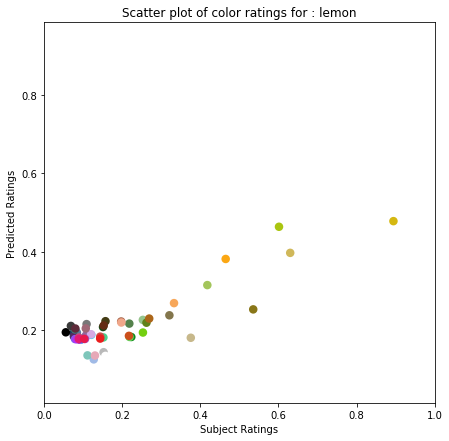

In [8]:
# Sparse features from Analysis I
minErrFeature1 = (4, 24, 29)
errSph, corrSph, win0_m1, win1_m1, win2_m1 = getRatings(minErrFeature1)

In [9]:
errSph

[1.090637500088453,
 1.6940285320965964,
 0.7221912320172911,
 0.8762102519102106,
 0.8115614598730841,
 1.1119662248294506,
 0.8878487769805122,
 1.6108840716505395,
 1.4893629563195332,
 1.0054558576780608,
 1.3378782960518008,
 0.6817235062735968]

In [10]:
corrSph

[0.8002819902676366,
 0.6124550194047277,
 0.6489145276051672,
 0.8060018199368434,
 0.8139935599951174,
 0.5960609860813589,
 0.6183923055538435,
 0.6679787205875284,
 0.608541996287167,
 0.8620303881035154,
 0.8586290816046185,
 0.8706169319568187]

# Regression on top 3 spherical + cyindrical features

Score is : 0.44
Coefficients:  [0.14515857 0.18636818 0.04373024 0.1969381 ]

Mean squared error: 0.0188
Variance score: 0.44
The true squared error (in color ratings) for left out fruit mango is: 0.9207

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.8125
p-value 0.0000


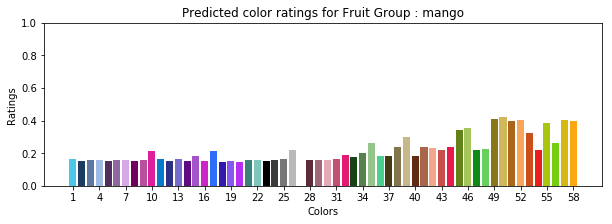

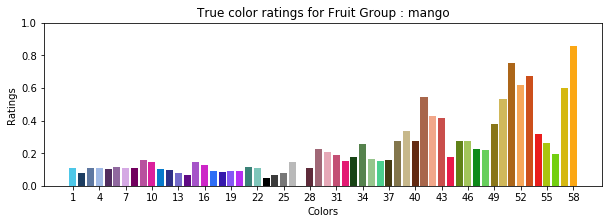

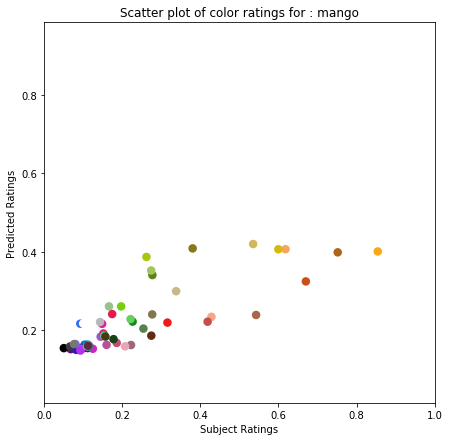

Score is : 0.02
Coefficients:  [0.13905011 0.23236842 0.01861164 0.18800855]

Mean squared error: 0.0360
Variance score: 0.02
The true squared error (in color ratings) for left out fruit watermelon is: 1.7021

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.5879
p-value 0.0000


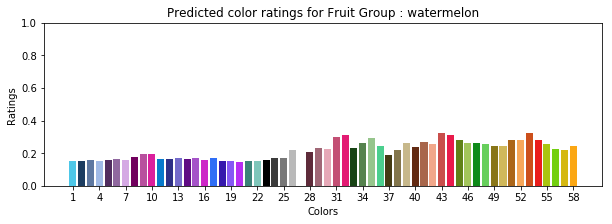

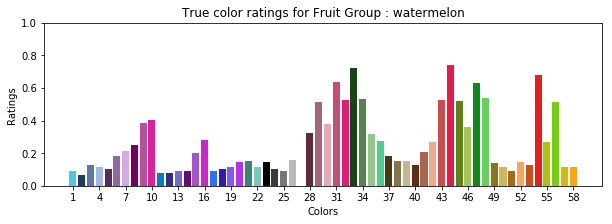

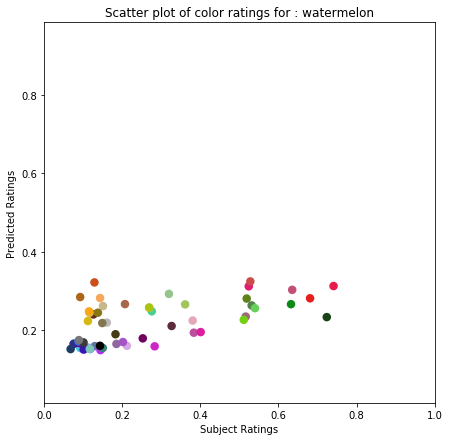

Score is : 0.37
Coefficients:  [0.14344205 0.19206711 0.05101044 0.1969415 ]

Mean squared error: 0.0126
Variance score: 0.37
The true squared error (in color ratings) for left out fruit honeydew is: 0.5446

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.7675
p-value 0.0000


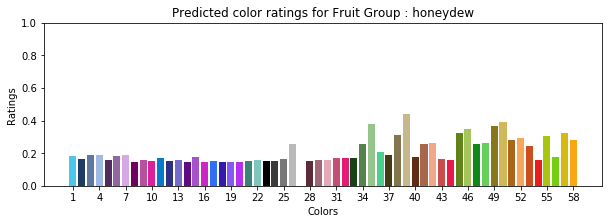

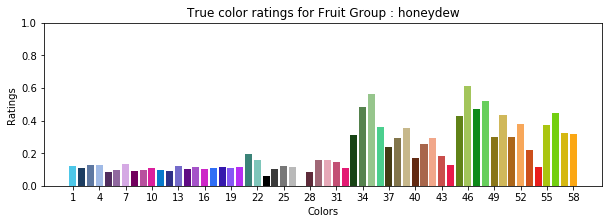

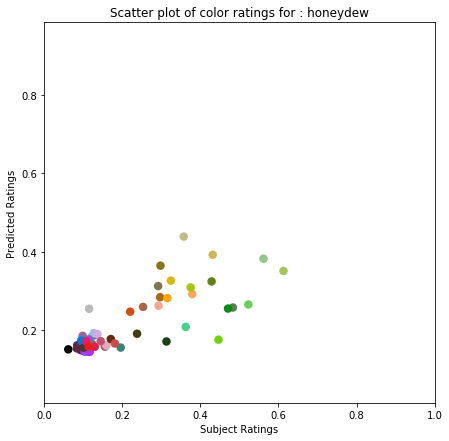

Score is : 0.41
Coefficients:  [0.14410144 0.2015637  0.05182994 0.18365944]

Mean squared error: 0.0184
Variance score: 0.41
The true squared error (in color ratings) for left out fruit cantaloupe is: 0.7896

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.8102
p-value 0.0000


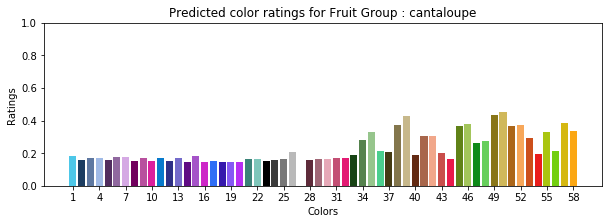

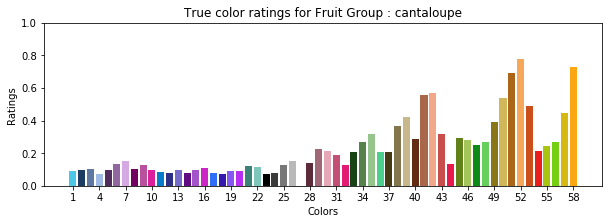

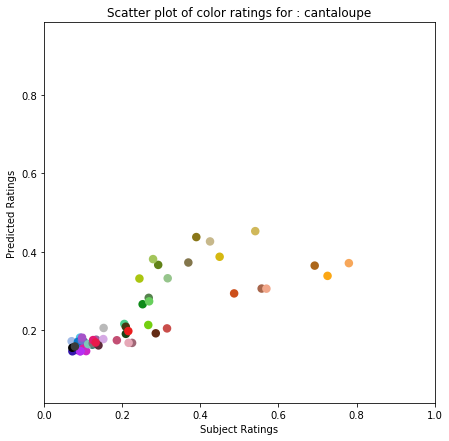

Score is : 0.26
Coefficients:  [0.14174927 0.19738253 0.0561804  0.18992961]

Mean squared error: 0.0180
Variance score: 0.26
The true squared error (in color ratings) for left out fruit grapefruit is: 0.7696

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.7479
p-value 0.0000


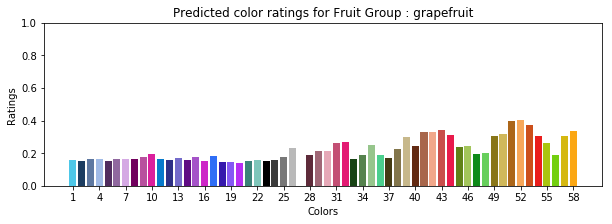

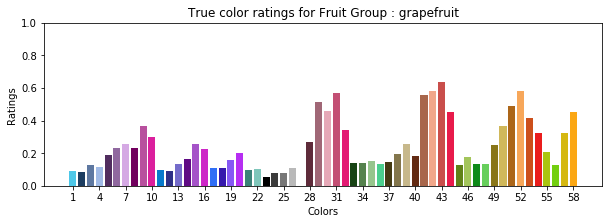

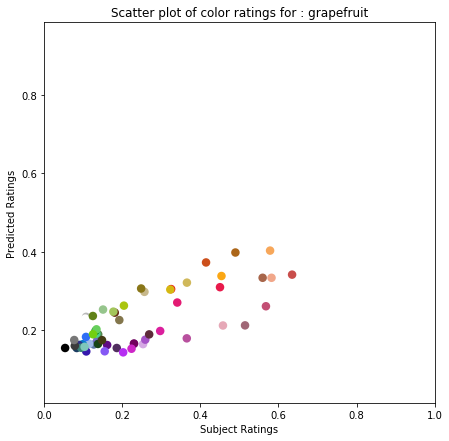

Score is : 0.15
Coefficients:  [0.14234296 0.21735796 0.03747688 0.18709686]

Mean squared error: 0.0231
Variance score: 0.15
The true squared error (in color ratings) for left out fruit strawberry is: 1.1151

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.5550
p-value 0.0000


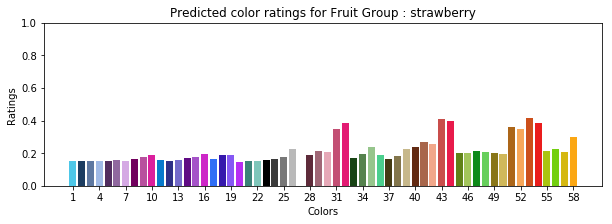

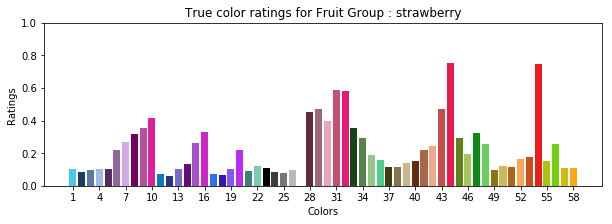

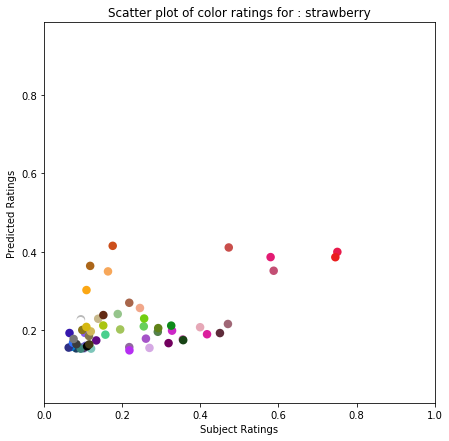

Score is : 0.21
Coefficients:  [0.14407742 0.21909354 0.03543046 0.18539378]

Mean squared error: 0.0188
Variance score: 0.21
The true squared error (in color ratings) for left out fruit raspberry is: 0.9007

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.6010
p-value 0.0000


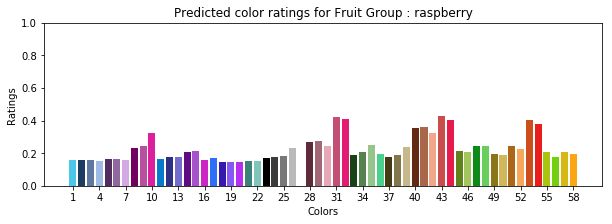

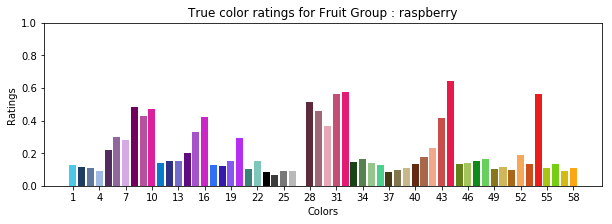

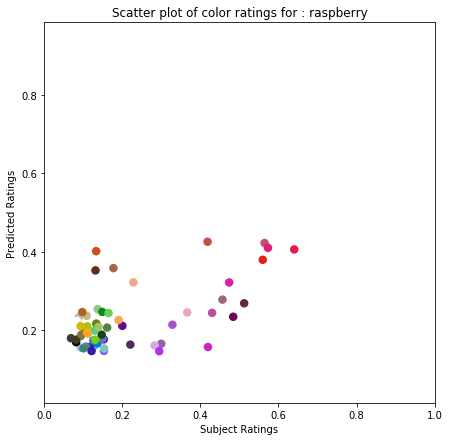

Score is : 0.22
Coefficients:  [0.14351914 0.19014751 0.04916076 0.19873405]

Mean squared error: 0.0333
Variance score: 0.22
The true squared error (in color ratings) for left out fruit blueberry is: 1.6169

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.7033
p-value 0.0000


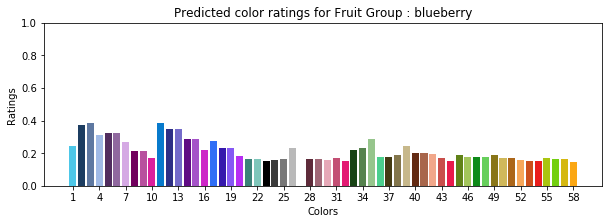

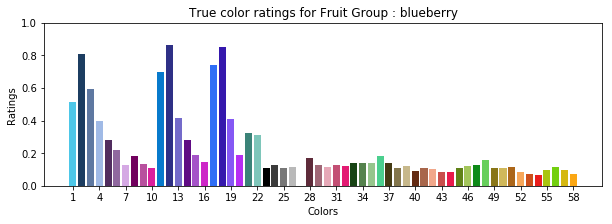

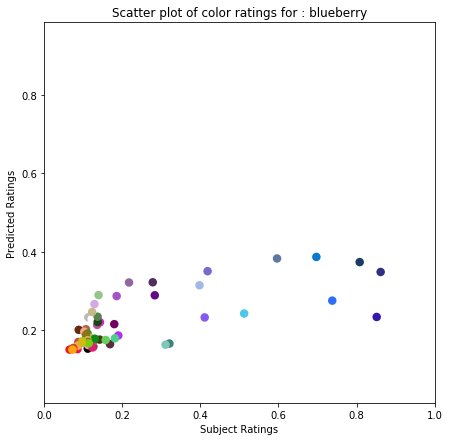

Score is : 0.24
Coefficients:  [0.14615461 0.22586347 0.0465455  0.16670454]

Mean squared error: 0.0273
Variance score: 0.24
The true squared error (in color ratings) for left out fruit avocado is: 1.3371

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.6431
p-value 0.0000


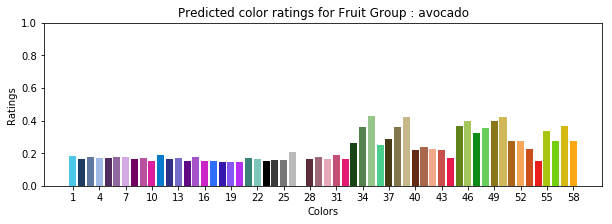

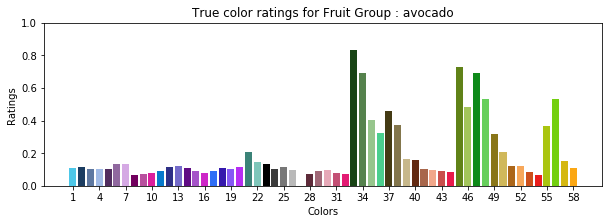

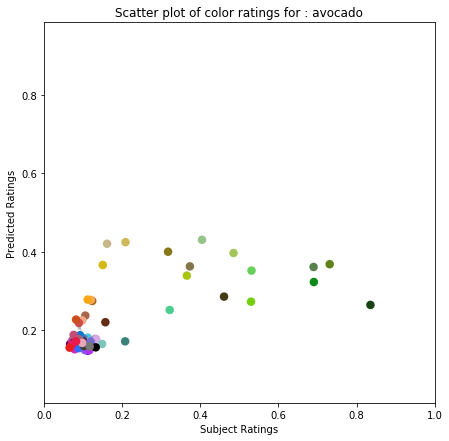

Score is : 0.47
Coefficients:  [0.14742041 0.21112463 0.02487805 0.18599981]

Mean squared error: 0.0197
Variance score: 0.47
The true squared error (in color ratings) for left out fruit orange is: 0.9403

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.8186
p-value 0.0000


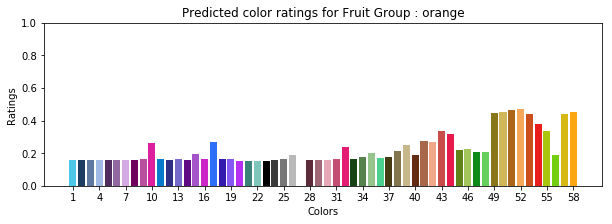

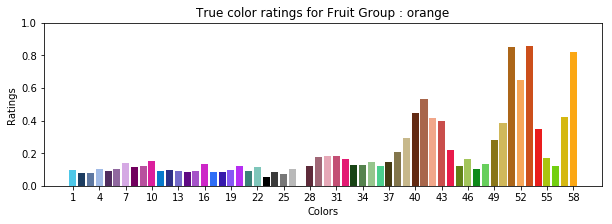

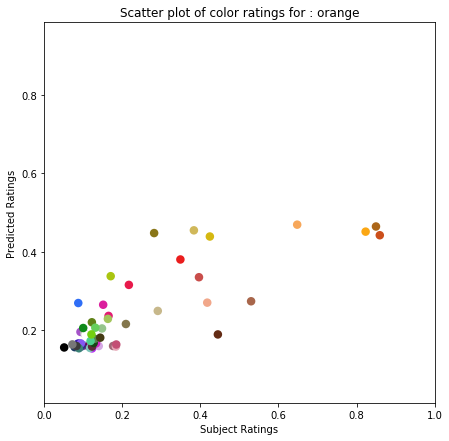

Score is : 0.44
Coefficients:  [0.14831223 0.19726802 0.03422685 0.18673795]

Mean squared error: 0.0248
Variance score: 0.44
The true squared error (in color ratings) for left out fruit lime is: 1.2464

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.8219
p-value 0.0000


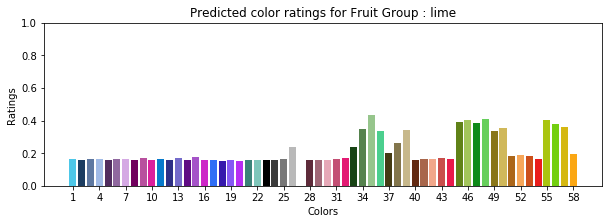

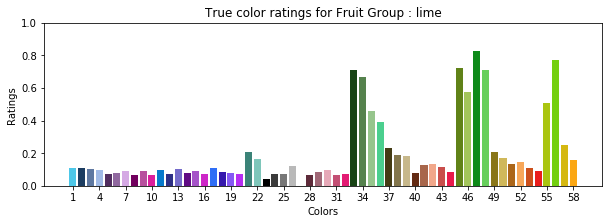

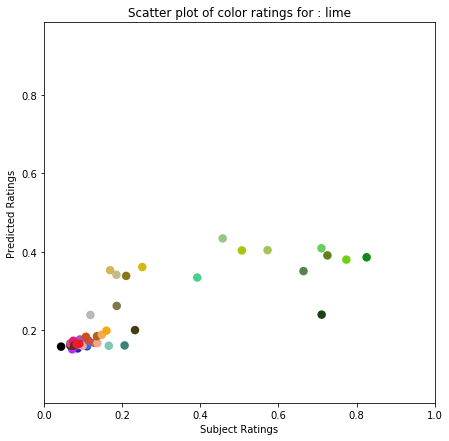

Score is : 0.54
Coefficients:  [0.14793766 0.21173878 0.01662129 0.19152274]

Mean squared error: 0.0119
Variance score: 0.54
The true squared error (in color ratings) for left out fruit lemon is: 0.5535

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.8661
p-value 0.0000


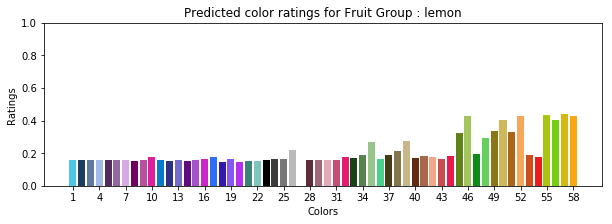

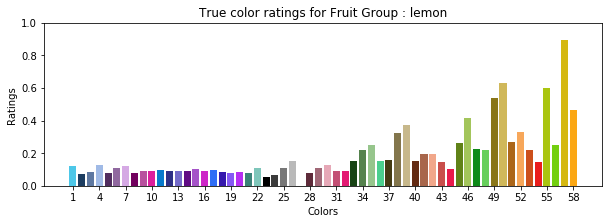

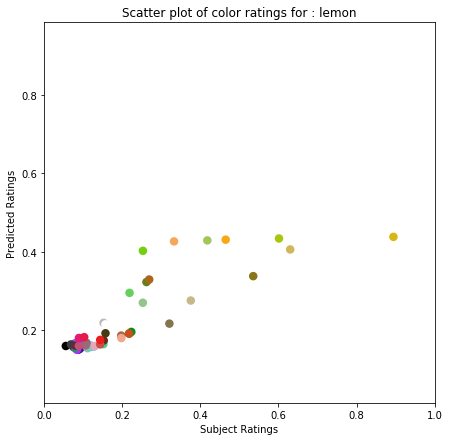

In [11]:
# Sparse features from Analysis II
minErrFeature2 = (54, 78, 179)
errSphCyl, corrSphCyl,  win0_m2, win1_m2, win2_m2 = getRatings(minErrFeature2)

# Regression on top 3 Spherical + Cylindrical + Categorical

Score is : 0.38
Coefficients:  [0.13934662 0.0798443  0.18407744 0.35132456]

Mean squared error: 0.0210
Variance score: 0.38
The true squared error (in color ratings) for left out fruit mango is: 0.9742

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.7815
p-value 0.0000


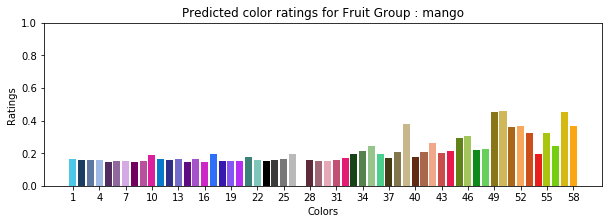

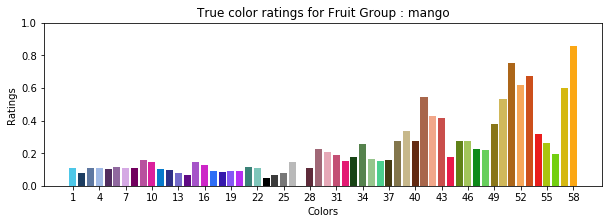

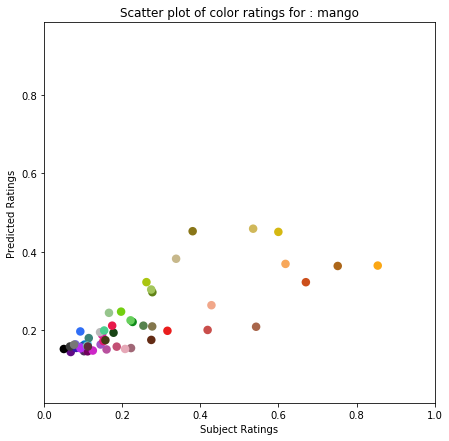

Score is : 0.05
Coefficients:  [0.13296251 0.11630343 0.17415933 0.34268859]

Mean squared error: 0.0350
Variance score: 0.05
The true squared error (in color ratings) for left out fruit watermelon is: 1.4470

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.7146
p-value 0.0000


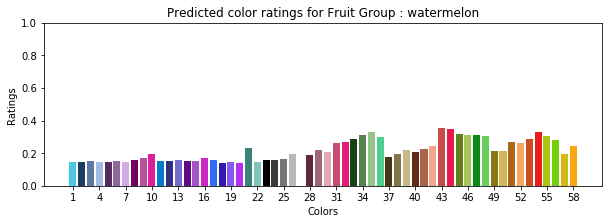

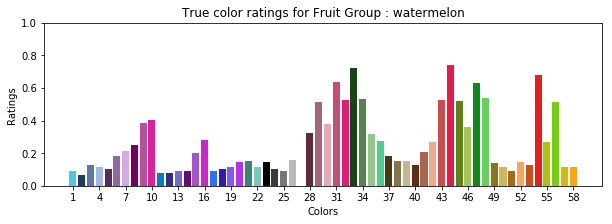

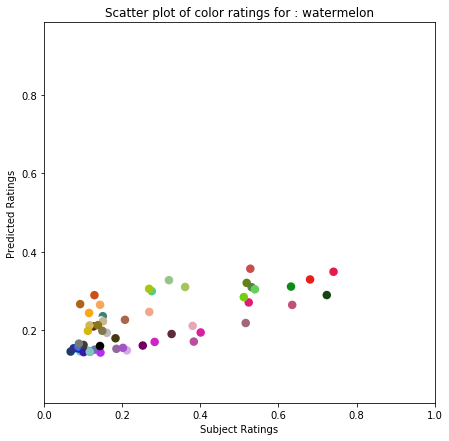

Score is : 0.34
Coefficients:  [0.138194   0.09110332 0.18654289 0.34618765]

Mean squared error: 0.0132
Variance score: 0.34
The true squared error (in color ratings) for left out fruit honeydew is: 0.4694

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.8252
p-value 0.0000


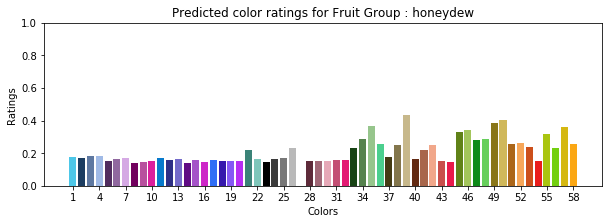

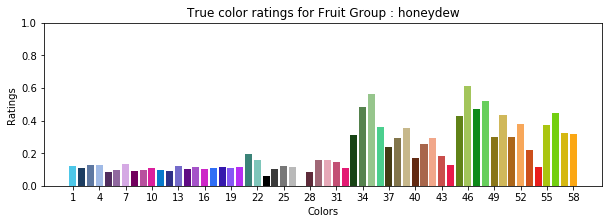

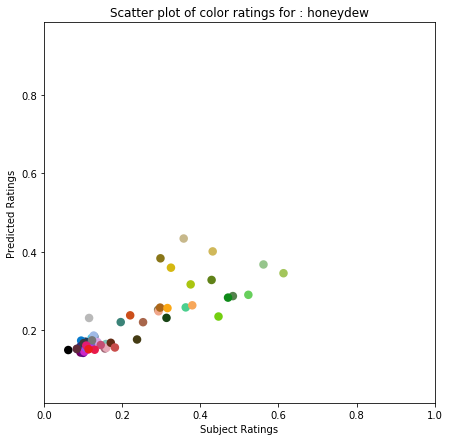

Score is : 0.29
Coefficients:  [0.13844161 0.098594   0.16968939 0.36111112]

Mean squared error: 0.0220
Variance score: 0.29
The true squared error (in color ratings) for left out fruit cantaloupe is: 0.8215

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.7942
p-value 0.0000


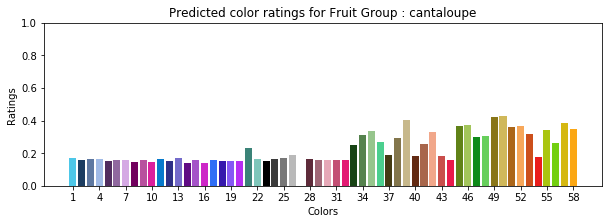

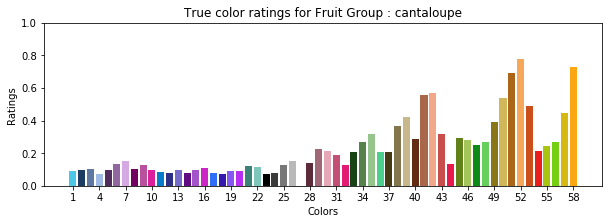

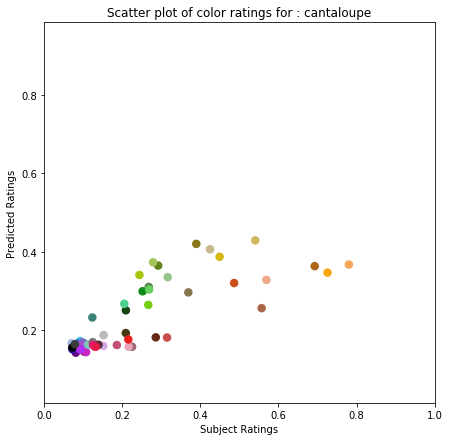

Score is : 0.20
Coefficients:  [0.13569939 0.10089962 0.1789105  0.34632698]

Mean squared error: 0.0195
Variance score: 0.20
The true squared error (in color ratings) for left out fruit grapefruit is: 0.7951

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.7415
p-value 0.0000


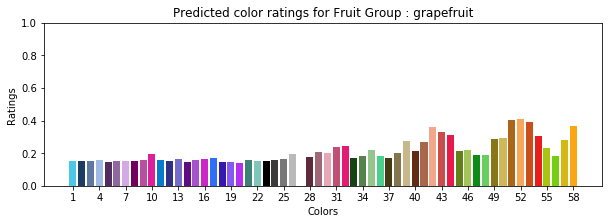

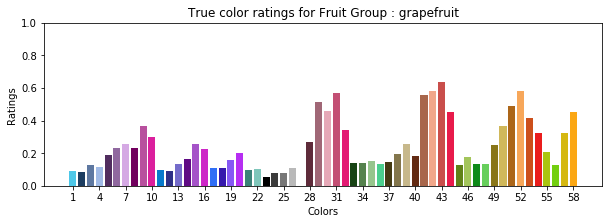

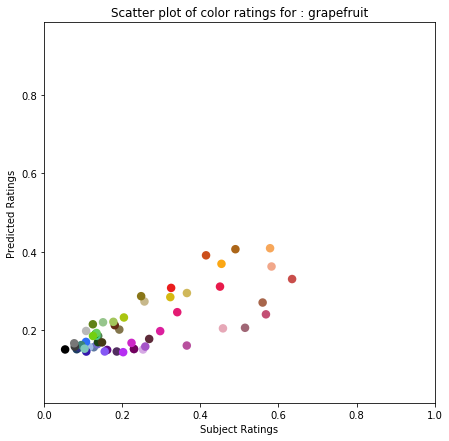

Score is : 0.25
Coefficients:  [0.13656594 0.11536661 0.17542557 0.3283514 ]

Mean squared error: 0.0204
Variance score: 0.25
The true squared error (in color ratings) for left out fruit strawberry is: 0.9482

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.6657
p-value 0.0000


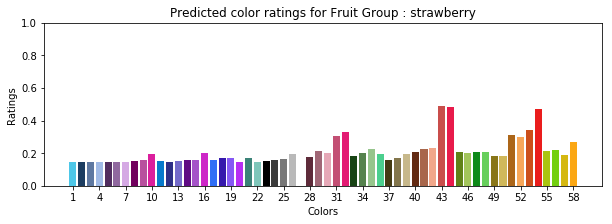

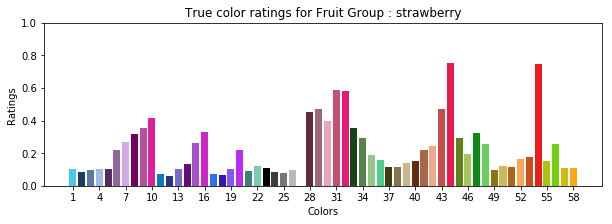

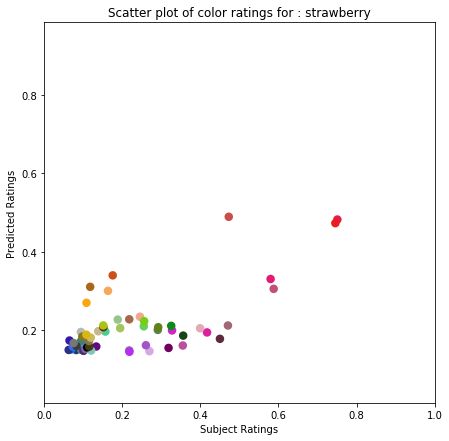

Score is : 0.28
Coefficients:  [0.13824847 0.11518252 0.17037524 0.33290663]

Mean squared error: 0.0173
Variance score: 0.28
The true squared error (in color ratings) for left out fruit raspberry is: 0.8276

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.6467
p-value 0.0000


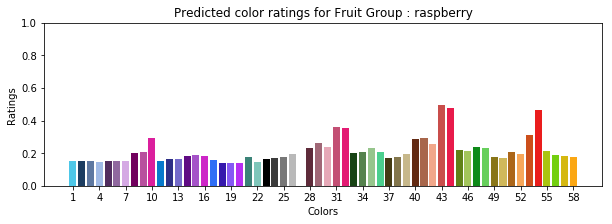

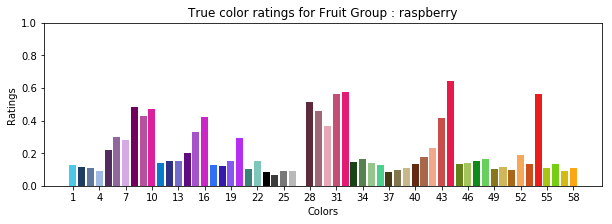

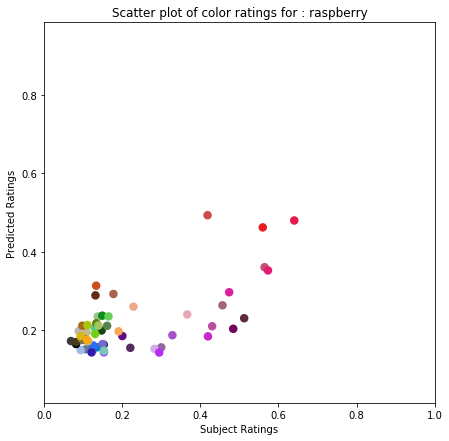

Score is : 0.52
Coefficients:  [0.1402374  0.11576745 0.18479499 0.29562578]

Mean squared error: 0.0203
Variance score: 0.52
The true squared error (in color ratings) for left out fruit blueberry is: 0.8816

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.8837
p-value 0.0000


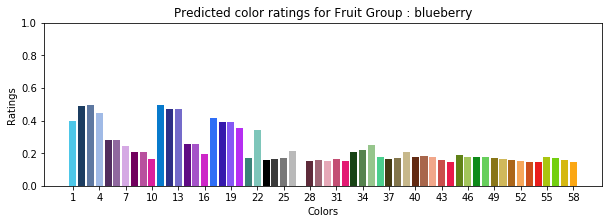

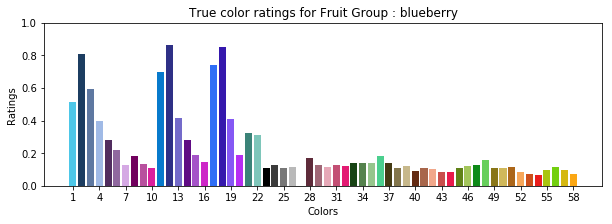

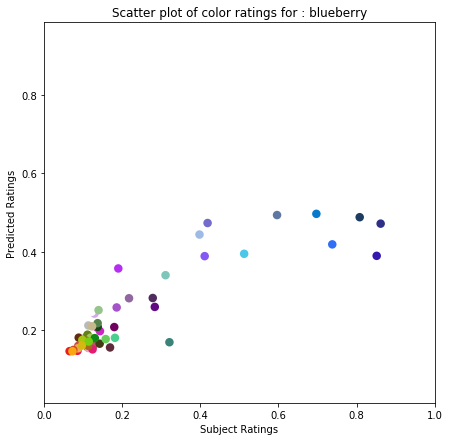

Score is : 0.41
Coefficients:  [0.14158752 0.1316684  0.15950344 0.31774779]

Mean squared error: 0.0210
Variance score: 0.41
The true squared error (in color ratings) for left out fruit avocado is: 0.9495

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.8082
p-value 0.0000


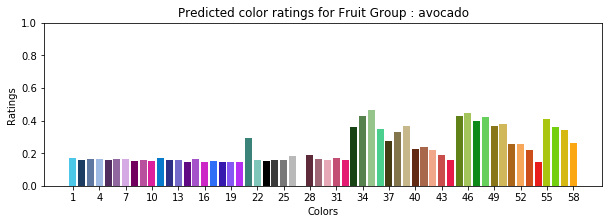

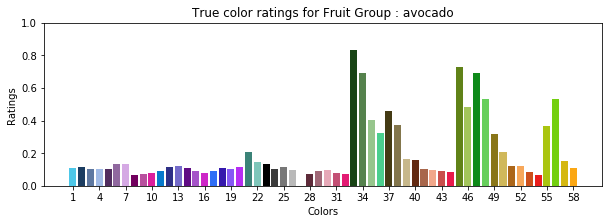

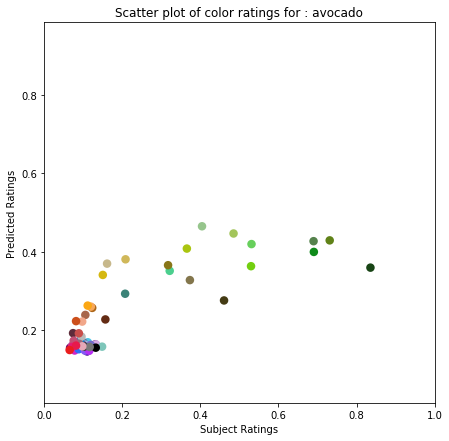

Score is : 0.62
Coefficients:  [0.14185189 0.10621241 0.17226385 0.31896253]

Mean squared error: 0.0142
Variance score: 0.62
The true squared error (in color ratings) for left out fruit orange is: 0.6450

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.9041
p-value 0.0000


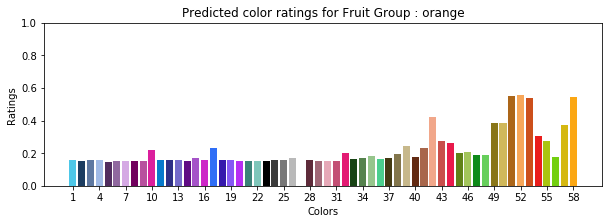

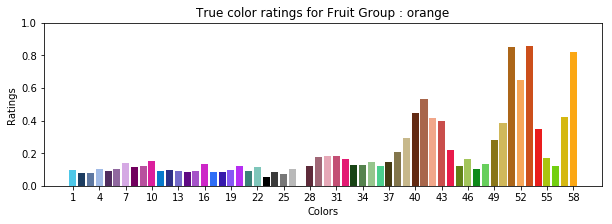

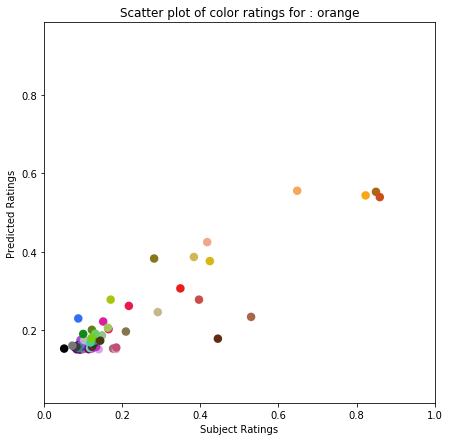

Score is : 0.65
Coefficients:  [0.14327948 0.10933493 0.17641101 0.30733712]

Mean squared error: 0.0152
Variance score: 0.65
The true squared error (in color ratings) for left out fruit lime is: 0.6744

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.9265
p-value 0.0000


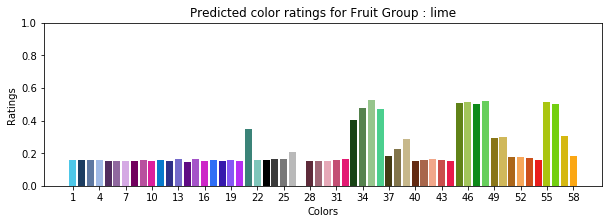

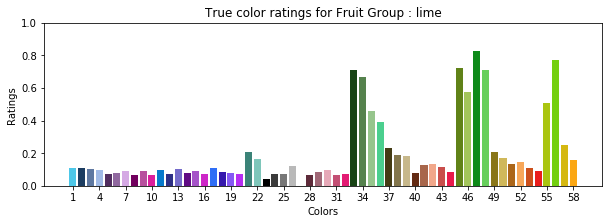

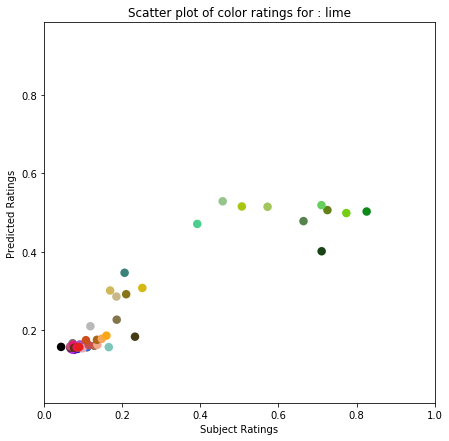

Score is : 0.67
Coefficients:  [0.14245817 0.09243213 0.1789178  0.33141167]

Mean squared error: 0.0085
Variance score: 0.67
The true squared error (in color ratings) for left out fruit lemon is: 0.3830

Pearson’s correlation coefficient (between true ratings and avg predicted ratings) is 0.9271
p-value 0.0000


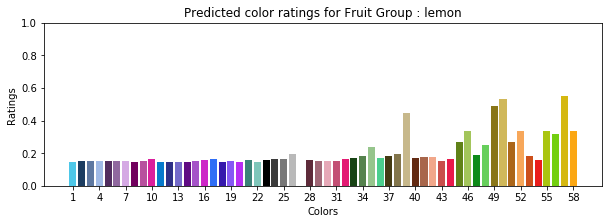

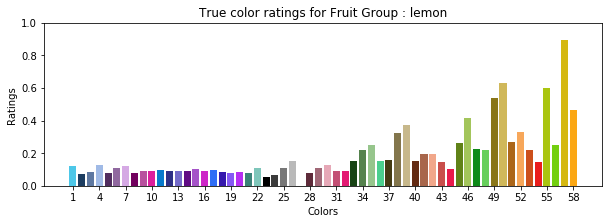

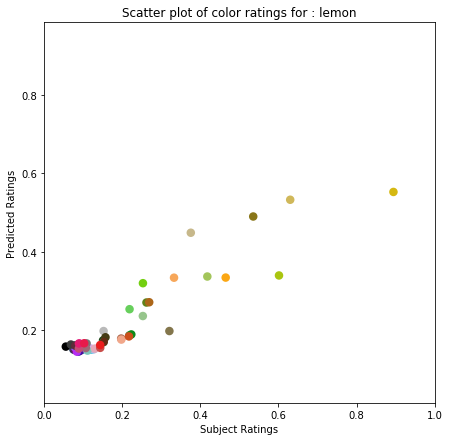

In [12]:
# Sparse features from Analysis III
minErrFeature3 = (54, 179, 180)
errSphCylCat, corrSphCylCat,  win0_m3, win1_m3, win2_m3 = getRatings(minErrFeature3)

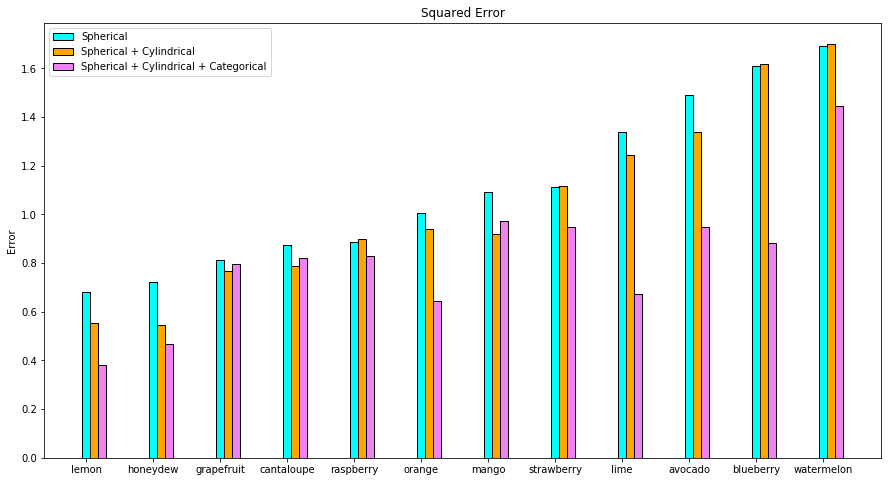

In [13]:
temp  = errSph[:]
indices = np.argsort(temp)
label = [allConcepts[i] for i in indices]

barWidth = 1.2
r1 = range(1,121,10)
r2 = [x + barWidth for x in r1]
r3 = [x + 2*barWidth for x in r1]

#t.bar(r1, bars1, width = barWidth, color = 'blue', edgecolor = 'black', yerr=yer1, capsize=7, label='poacee')
fig = plt.figure(figsize=(15,8))
plt.bar(r1,sorted(errSph),width = barWidth, color = 'cyan', edgecolor = 'black',label='Spherical')
plt.bar(r2,[errSphCyl[t] for t in indices],width = barWidth, color = 'orange', edgecolor = 'black',label='Spherical + Cylindrical')
plt.bar(r3,[errSphCylCat[t] for t in indices],width = barWidth, color = 'violet', edgecolor = 'black',label='Spherical + Cylindrical + Categorical')
plt.xticks(range(1,121,10),label)
plt.title("Squared Error")
plt.ylabel('Error')
plt.legend()
#plt.savefig('ErrWithIncreasingRadial.pdf')
plt.show()

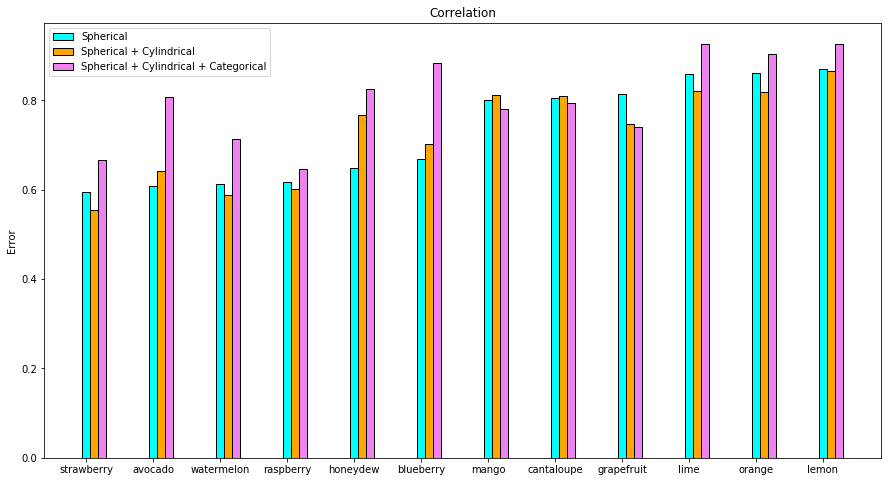

In [14]:
temp  = corrSph[:]
indices = np.argsort(temp)
label = [allConcepts[i] for i in indices]

barWidth = 1.2
r1 = range(1,121,10)
r2 = [x + barWidth for x in r1]
r3 = [x + 2*barWidth for x in r1]
plt.close('all')
#t.bar(r1, bars1, width = barWidth, color = 'blue', edgecolor = 'black', yerr=yer1, capsize=7, label='poacee')
fig = plt.figure(figsize=(15,8))
plt.bar(r1,sorted(corrSph),width = barWidth, color = 'cyan', edgecolor = 'black',label='Spherical')
plt.bar(r2,[corrSphCyl[t] for t in indices],width = barWidth, color = 'orange', edgecolor = 'black',label='Spherical + Cylindrical')
plt.bar(r3,[corrSphCylCat[t] for t in indices],width = barWidth, color = 'violet', edgecolor = 'black',label='Spherical + Cylindrical + Categorical')
plt.xticks(range(1,121,10),label)
plt.title("Correlation")
plt.ylabel('Error')
plt.legend()
#plt.savefig('CorrWithIncreasingRadial.eps')
plt.show()

In [15]:
# # For plots of correlations
# err, corr, win0, win1, win2 = getRatings(minErrFeature3, True)

# Figure2: Scatter plots for the best model

In [16]:
import matplotlib as mpl
mpl.rcParams.update({'font.size': 9})
def createScatterPlots(indices, win0, win1, win2,model_num):
    print("----------------------- Creating plots for Model ---------------",model_num)
    # print(indices)
    # print(win0)
    
    k = 1
    plt.close('all')

    plt.subplots(3,4,figsize=(10,10))
    for i in range(len(indices)-1,-1,-1):
        # Scatter plot

        arg = indices[i]
        trueRating = win1[arg]
        avg_pred = win2[arg]

        ax = plt.subplot(3,4,k,aspect='equal') #plt.figure(figsize=(7,7))
        #ax = f.add_subplot(3,4,k)
        plt.scatter(trueRating,avg_pred,c=colorDataRGB.values,marker = 'o',linewidths=2.5)
        if k == 1 or k == 5 or k == 9:
            plt.ylabel('Mean Predicted Rating')
        plt.xlabel('Mean Rating')
        s = allConcepts[arg]+"( %.2f )" %win0[arg]
        #print(s)
        plt.title(s)
        plt.xlim(0,1)
        plt.ylim(0,1)
        plt.yticks([0,0.5,1])
        plt.xticks([0,0.5,1])
        plt.tick_params(direction='in')
        plt.plot(np.unique(trueRating), np.poly1d(np.polyfit(trueRating, avg_pred, 1))(np.unique(trueRating)),'k--')
        k = k+1
    plotName = "Cartoon50_ScatterPlot_Model_"+str(model_num)+".pdf"
    #plt.savefig(plotName)
    plt.show()
    
    

----------------------- Creating plots for Model --------------- 1


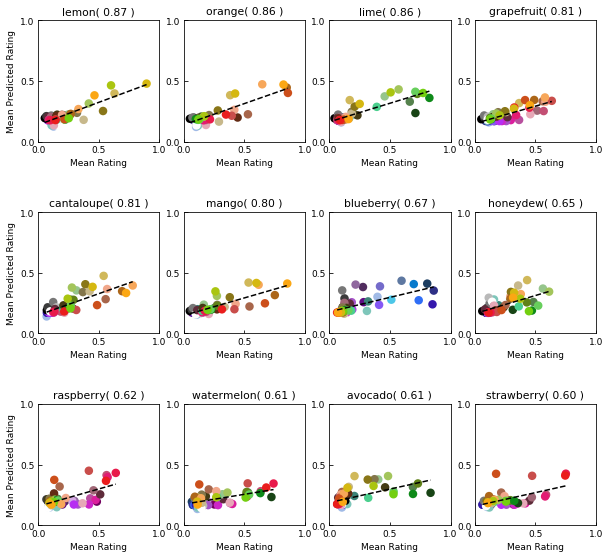

----------------------- Creating plots for Model --------------- 2


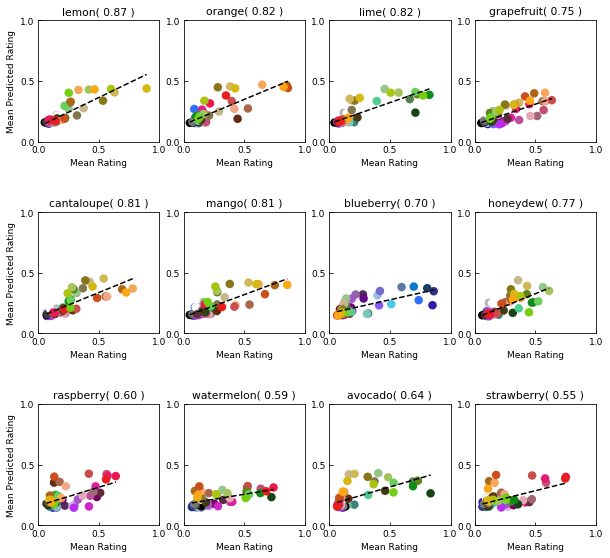

----------------------- Creating plots for Model --------------- 3


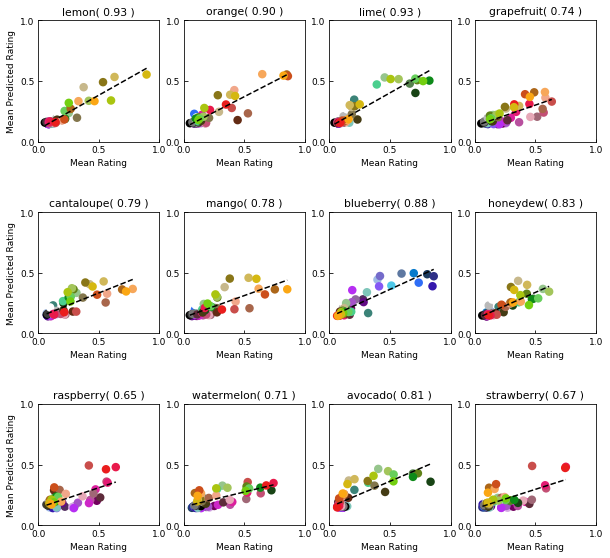

In [17]:
indices = np.argsort(win0_m1) # Want in the order of model 1 correlations
createScatterPlots(indices, win0_m1, win1_m1, win2_m1,1)
createScatterPlots(indices, win0_m2, win1_m2, win2_m2,2)
createScatterPlots(indices,win0_m3, win1_m3, win2_m3,3)

In [18]:
# indices = np.argsort(win0_m3)
# print(indices)
# print(win0_m3)

In [19]:
# k = 1
# plt.close('all')
# import matplotlib as mpl
# mpl.rcParams.update({'font.size': 9})
# plt.subplots(3,4,figsize=(10,10))
# for i in range(len(indices)-1,-1,-1):
#     # Scatter plot
    
#     arg = indices[i]
#     trueRating = win1_m3[arg]
#     avg_pred = win2_m3[arg]
    
#     ax = plt.subplot(3,4,k,aspect='equal') #plt.figure(figsize=(7,7))
#     #ax = f.add_subplot(3,4,k)
#     plt.scatter(trueRating,avg_pred,c=colorDataRGB.values,marker = 'o',linewidths=2.5)
#     if k == 1 or k == 5 or k == 9:
#         plt.ylabel('Mean Predicted Rating')
#     plt.xlabel('Mean Rating')
#     s = allConcepts[arg]+"( %.2f )" %win0_m3[arg]
#     #print(s)
#     plt.title(s)
#     plt.xlim(0,1)
#     plt.ylim(0,1)
#     plt.yticks([0,0.5,1])
#     plt.xticks([0,0.5,1])
#     plt.tick_params(direction='in')
#     plt.plot(np.unique(trueRating), np.poly1d(np.polyfit(trueRating, avg_pred, 1))(np.unique(trueRating)),'k--')
#     k = k+1
# plt.savefig('ScatterPlotBestModel.pdf')
# plt.show()

In [20]:
cor_m3,_ = stats.pearsonr(np.array(win2_m3).flatten(), np.array(win1_m3).flatten())
cor_m2,_ = stats.pearsonr(np.array(win2_m2).flatten(), np.array(win1_m2).flatten())
cor_m1,_ = stats.pearsonr(np.array(win2_m1).flatten(), np.array(win1_m1).flatten())

In [21]:
[cor_m1, cor_m2, cor_m3]

[0.7216258683584259, 0.7208937076784797, 0.8020667442786569]

In [22]:
ratingsCartoon = np.column_stack((np.array(win2_m1).flatten(), np.array(win2_m2).flatten(), np.array(win2_m3).flatten()))

In [24]:
# df = pd.DataFrame(ratingsCartoon)
# ## save to xlsx file

# filepath = 'RatingsCartoon.csv'
# df.to_csv(filepath, index=False)


In [25]:
print("For CARTOON 50")
print("model 1:", cor_m1)
print("model 2:",cor_m2)
print("model :3",cor_m3)


For CARTOON 50
model 1: 0.7216258683584259
model 2: 0.7208937076784797
model :3 0.8020667442786569


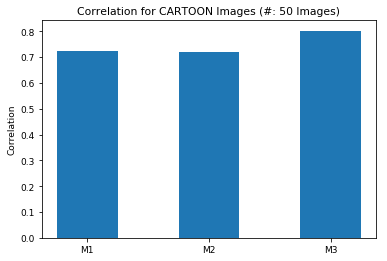

In [26]:
barWidth = 0.5
plt.bar(range(1,4),[cor_m1, cor_m2, cor_m3], width = barWidth)
plt.xticks(range(1,4),['M1','M2','M3'])
plt.title("Correlation for CARTOON Images (#: 50 Images)")
plt.ylabel('Correlation')
plt.show()

# Figure 3: Error and Correlation stem plots for #Images: 50

In [27]:
# temp  = errSph
# print(np.argsort(temp))
# indices = np.flipud(np.argsort(temp))
# indices

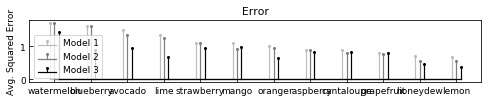

In [28]:
plt.close('all')
temp  = errSph[:]
indices = np.flipud(np.argsort(temp)) # Sort and get indices and reverse order
label = [allConcepts[i] for i in indices]

barWidth = 1.2
r1 = range(1,121,10)
r2 = [x + barWidth for x in r1]
r3 = [x + 2*barWidth for x in r1]

#t.bar(r1, bars1, width = barWidth, color = 'blue', edgecolor = 'black', yerr=yer1, capsize=7, label='poacee')
fig = plt.figure(figsize =(7,1.5)) # (12,6)
#linefmt=None, markerfmt=None, basefmt=None, bottom=0, label=None
mline1 = plt.stem(r1,sorted(errSph)[::-1], linefmt='-',label='Model 1')
plt.setp(mline1, color=[0.737,0.737,0.737], linewidth=1.2, markersize = 2)
#plt.setp(sline1, linewidth=0.8)


mline2 = plt.stem(r2,[errSphCyl[t] for t in indices],label='Model 2')
plt.setp(mline2, color=[0.486,0.486,0.486], linewidth=1.2, markersize = 2)

mline3 = plt.stem(r3,[errSphCylCat[t] for t in indices],label='Model 3')
plt.setp(mline3, color=[0,0,0], linewidth=1.2, markersize = 2)

plt.xticks(r2,label)
plt.tick_params(direction='in')
plt.title("Error")
plt.ylabel('Avg. Squared Error')
plt.legend()
plt.tight_layout()
plt.savefig('ErrorCartoon50_AllModels.pdf')
plt.show()

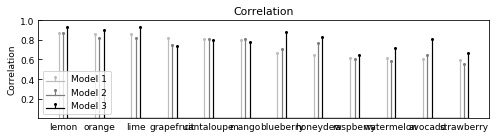

In [29]:
plt.close('all')
temp  = corrSph[:]
indices = np.flipud(np.argsort(temp)) # Sort and get indices and reverse order
label = [allConcepts[i] for i in indices]

barWidth = 1.2
r1 = range(1,121,10)
r2 = [x + barWidth for x in r1]
r3 = [x + 2*barWidth for x in r1]

fig = plt.figure(figsize =(7,2))
#linefmt=None, markerfmt=None, basefmt=None, bottom=0, label=None
mline1 = plt.stem(r1,sorted(corrSph)[::-1], linefmt='-',label='Model 1')
plt.setp(mline1, color=[0.737,0.737,0.737], linewidth=1.2, markersize = 2)

mline2 = plt.stem(r2,[corrSphCyl[t] for t in indices],label='Model 2')
plt.setp(mline2, color=[0.486,0.486,0.486], linewidth=1.2, markersize = 2)

mline3 = plt.stem(r3,[corrSphCylCat[t] for t in indices],label='Model 3')
plt.setp(mline3, color=[0,0,0], linewidth=1.2, markersize = 2)

plt.xticks(r2,label)
plt.yticks([0.2, 0.4,0.6, 0.8, 1])
plt.tick_params(direction='in')
plt.title("Correlation")
plt.ylabel('Correlation')
plt.legend()
plt.ylim(0,1)

plt.tight_layout() 
plt.savefig('CorrelationCartoon50_AllModels.pdf')
plt.show()

# Plot for Lemon Lime Blueberry

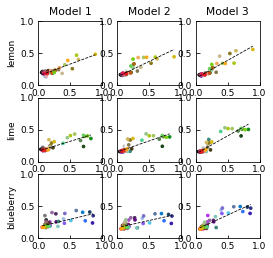

In [30]:
allConcepts = ['mango','watermelon','honeydew','cantaloupe','grapefruit','strawberry','raspberry','blueberry','avocado','orange','lime','lemon']
ind1 = 11 #Lemon
ind2 = 10 # Lime
ind3 = 7 # Blueberry
plt.close('all')
k = 1
title = ['Model 1', 'Model 2', 'Model 3']
plt.subplots(3,3,figsize=(4,4))
for i in range(3):
    # Scatter plot
    if i == 0:
        ind = 11
    elif i == 1:
        ind = 10
    else:
        ind = 7
    
    for j in range(3):
        if j == 0:
            trueRating = np.copy(win1_m1[ind])
            avg_pred =np.copy( win2_m1[ind])
        elif j == 1:
            trueRating = np.copy(win1_m2[ind])
            avg_pred = np.copy(win2_m2[ind])
        else:
            trueRating = np.copy(win1_m3[ind])
            avg_pred = np.copy(win2_m3[ind])

        ax = plt.subplot(3,3,k,aspect='equal') #plt.figure(figsize=(7,7))
        plt.scatter(trueRating, avg_pred,c=colorDataRGB.values,marker = 'o',s = 7)
        if k == 1 or k == 4 or k == 7:
            plt.ylabel(allConcepts[ind])
#         plt.xlabel('Mean Rating')
    #     s = allConcepts[arg]+"( %.2f )" %win0[arg]
    #     #print(s)
    #     plt.title(s)
        if k in [1,2,3]:
            plt.title(title[k-1])
        plt.xlim(0,1)
        plt.ylim(0,1)
        plt.yticks([0,0.5,1])
        plt.xticks([0,0.5,1])
        plt.tick_params(direction='in')
        plt.plot(np.unique(trueRating), np.poly1d(np.polyfit(trueRating, avg_pred, 1))(np.unique(trueRating)),'k--',linewidth=0.8)
        k = k+1
#plt.tight_layout() 
plt.savefig('LemonLimeBlueberry_ScatterPlotCartoon50.pdf')
plt.show()

In [31]:
print("model 1:",np.mean(errSph))
print("model 2:",np.mean(errSphCyl))
print("model 3:",np.mean(errSphCylCat))

model 1: 1.109979055480761
model 2: 1.0363843040579372
model 3: 0.8180535623890175


In [33]:
print(corrSphCylCat)

[0.781524828440574, 0.714571328468224, 0.825159866174106, 0.7942387231076063, 0.7414536662866953, 0.6656776560433498, 0.646704823478678, 0.8837439344717491, 0.8082312089825369, 0.9041306188233534, 0.9265401211764899, 0.927062108427405]
